# Time Series Analysis Using Bitcoin Price Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn import linear_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import seaborn as sns
import statistics
import datetime
import plotly.express as px

In [2]:
btc_hist_data = pd.read_csv('/Users/matthewkurkemelis/desktop/BTC Analysis/btc_price_data.csv', parse_dates=['Date'])

In [3]:
btc_price = pd.concat([btc_hist_data['Date'], btc_hist_data['Price']], axis=1)[::-1]

In [4]:
#btc_price.tail()

In [5]:
btc_price['Price'] = btc_price['Price'].apply(lambda x: x.replace(',', ''))

In [6]:
btc_price['Price'] = btc_price['Price'].astype(float)

In [7]:
btc_price.set_index('Date', inplace=True)

In [8]:
#btc_price.drop(columns=['index'], inplace=True)

In [9]:
btc_price[-365:]

,Price
Date,
2019-04-09,5158.4
2019-04-10,5307.8
2019-04-11,5022.6
2019-04-12,5054.2
2019-04-13,5051.8
...,...
2020-04-03,6735.9
2020-04-04,6857.4
2020-04-05,6772.7


In [10]:
def last_365days(btc_price_column):
    '''returns the last 100 days as a Pandas series'''
    
    if len(btc_price_column > 365):
        return btc_price_column[-365:]
    else:
        return btc_price_column

In [11]:
stdev_price = statistics.stdev(last_365days(btc_price['Price']))

In [12]:
btc_price['pct_change'] = btc_price['Price'].pct_change()

In [13]:
btc_price.dropna(inplace=True)

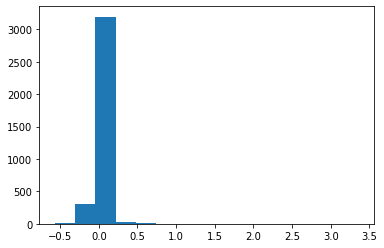

In [14]:
plt.hist(btc_price['pct_change'], bins=15);

In [15]:
stdev_ret = statistics.stdev(last_365days(btc_price['pct_change']))

In [16]:
stdev_ret

0.044315129813632816

In [17]:
mean_ret = statistics.mean(last_365days(btc_price['pct_change']))

In [18]:
mean_ret

0.0019053228383893615

In [19]:
lst_pos_stdev_ret = [stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

In [20]:
lst_neg_stdev_ret = [-stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

In [21]:
_2stdev_ret = stdev_ret * 2

In [22]:
_2stdev_ret

0.08863025962726563

In [23]:
lst_pos_2stdev_ret = [_2stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

In [24]:
lst_neg_2stdev_ret = [-_2stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

In [25]:
_3stdev_ret = stdev_ret * 3

In [26]:
_3stdev_ret

0.13294538944089845

In [27]:
lst_pos_3stdev_ret = [_3stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

In [28]:
lst_neg_3stdev_ret = [-_3stdev_ret for x in range(len(last_365days(btc_price['pct_change'])))]

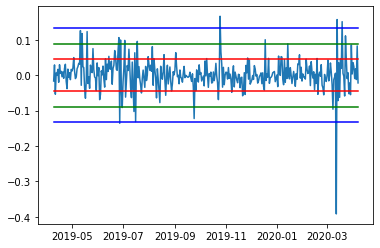

In [29]:
plt.plot(last_365days(btc_price['pct_change']).index, last_365days(btc_price['pct_change']))
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_stdev_ret, 'r')
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_stdev_ret, 'r')
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_2stdev_ret, 'g')
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_2stdev_ret, 'g')
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_3stdev_ret, 'b')
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_3stdev_ret, 'b')

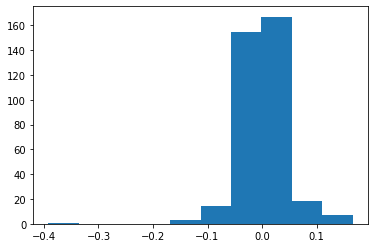

In [30]:
plt.hist(last_365days(btc_price['pct_change']));

In [31]:
outlier = last_365days(btc_price['pct_change']) > _3stdev_ret

In [32]:
def values_greater_3stdev(series):
    '''returns a list of vals that are greater than 3 standard deviations'''
    stdev = statistics.stdev(series)
    _3stdev = stdev * 3
    lst_outliers = []
    for item in series:
        if item > _3stdev or item < -_3stdev:
            lst_outliers.append(item)
    
    return lst_outliers

In [33]:
values_greater_3stdev(last_365days(btc_price['pct_change']))

[-0.13594819271574887,
 0.1664623385021622,
 -0.3918161081775907,
 0.15712805636137595,
 0.1511918528742493]

In [34]:
def simple_moving_avg(series, time_period=10):
    lst_of_vals = []
    ma_lst = [0 for x in range(time_period)]
    
    if time_period >= len(series):
        return "Cannot calculate moving average"
    
    for val in series:
        lst_of_vals.append(val)
        if (len(lst_of_vals) == time_period) and (len(ma_lst) != len(series)):
            avg = statistics.mean(lst_of_vals)
            ma_lst.append(avg)
            lst_of_vals.pop(0)

    
    return ma_lst

In [35]:
ma = simple_moving_avg(btc_price['pct_change'], 10)

In [36]:
ma_df = pd.DataFrame(ma)

In [37]:
ma_df.set_index(btc_price.index, inplace=True)

In [38]:
btc_price = pd.concat([btc_price, ma_df], axis=1)

In [39]:
def rolling_stdev(series, time_period=10, multiplication_coeff=1):
    '''function that takes in three parameters: series, time_period, and multiplication_coeff.
       series: array-like data structure
       time_period: 
       multiplication_coeff: value to multiply calculated standard deviation by. If not specified, it will default
       to 1, or just the normal standard deviation. (e.g., if 2, standard deviation * 2)
    '''
    
    lst_of_vals = []
    pos_stdev_val_lst = [0 for x in range(time_period)]
    neg_stdev_val_lst = [0 for x in range(time_period)]
    
    if time_period >= len(series):
        return "Cannot calculate rolling standard deviation"
    
    for val in series:
        lst_of_vals.append(val)
        if (len(lst_of_vals) == time_period) and (len(pos_stdev_val_lst) != len(series)):
            stdev = statistics.stdev(lst_of_vals) * multiplication_coeff
            pos_stdev_val_lst.append(stdev)
            neg_stdev_val_lst.append(-stdev)
            lst_of_vals.pop(0)

    
    return pos_stdev_val_lst, neg_stdev_val_lst

In [40]:
pos_stdev, neg_stdev = rolling_stdev(last_365days(btc_price['pct_change']), 10, 1)

In [41]:
pos_stdev_series = pd.Series(pos_stdev)

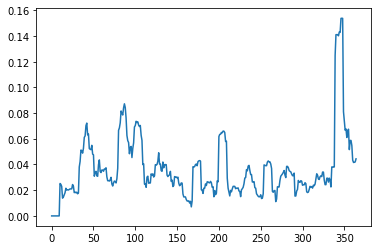

In [42]:
pos_stdev_series.plot()

In [43]:
neg_stdev_series = pd.Series(neg_stdev)

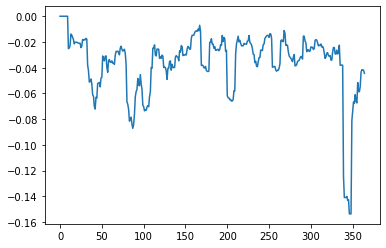

In [44]:
neg_stdev_series.plot()

In [45]:
btc_price.rename(columns={0:'10SMA_pct_change'},inplace=True)

In [46]:
btc_price['100SMA_btc_price'] = simple_moving_avg(btc_price['Price'], 100)

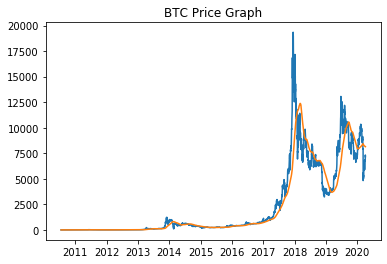

In [47]:
plt.plot(btc_price['Price']);
plt.plot(btc_price['100SMA_btc_price'])
plt.title('BTC Price Graph');

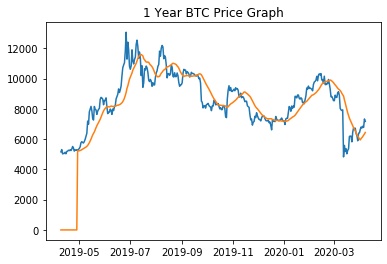

In [48]:
plt.plot(last_365days(btc_price['Price']));
plt.plot(last_365days(btc_price['Price']).index, simple_moving_avg(last_365days(btc_price['Price']), 20));
plt.title('1 Year BTC Price Graph');

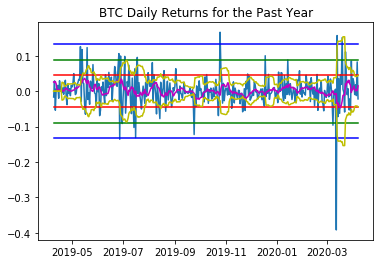

In [49]:
plt.plot(last_365days(btc_price['pct_change']).index, last_365days(btc_price['pct_change']));
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_stdev_ret, 'r');
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_stdev_ret, 'r');
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_2stdev_ret, 'g');
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_2stdev_ret, 'g');
plt.plot(last_365days(btc_price['pct_change']).index, lst_pos_3stdev_ret, 'b');
plt.plot(last_365days(btc_price['pct_change']).index, lst_neg_3stdev_ret, 'b');
plt.plot(last_365days(btc_price['pct_change']).index, last_365days(btc_price['10SMA_pct_change']), 'm');
plt.plot(last_365days(btc_price['pct_change']).index, pos_stdev_series, 'y');
plt.plot(last_365days(btc_price['pct_change']).index, neg_stdev_series, 'y');
plt.title('BTC Daily Returns for the Past Year');

Visually speaking, the last year of Bitcoin historical price data seems to show no underlying trend or seasonality; However, there are, what is seems to be, random, large spikes happening at irregular intervals. In order to conclude the underlying structure of the data, more formal statistical testing is required. 

In [50]:
# perform Dickey-Fuller test on the 'pct_change' column to test for stationarity in daily returns
from statsmodels.tsa.stattools import adfuller
DF_result_full = adfuller(btc_price['pct_change'], regresults=True)
DF_result_1yr = adfuller(last_365days(btc_price['pct_change']), regresults=True)
print(adfuller(btc_price['pct_change'][-100:]))
print('p-value for full history of BTC returns: ', f"{DF_result_full[1]:0.4f}")
print('p-value for 1-year BTC returns: ', f"{DF_result_1yr[1]:0.4f}")

(-4.100451399698739, 0.0009668618813334486, 3, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, -248.46865337293576)
p-value for full history of BTC returns:  0.0000
p-value for 1-year BTC returns:  0.0000


As you can see, the p-values are below the 1% and 5% (most widely used significance levels) showing that the time series of daily returns (column 'pct_change') can be considered stationary processes. A.K.A there is a low chance that there is non-stationarity present in those time series.

Now that we have a basic understanding of the data, its structure, and its summary statistics and how they change over time, we can try to forecast returns and prices. The data used for this part of the analysis is considered univariate because it consists of a single value over a certain period of time. We assume that the time steps are assumed to be evenly spread out (we are assuming the website we got the data from collecting Bitcoin prices each day at the same time). 

Because we may want to predict prices instead of return in the future, we will try to transform the Bitcoin prices time series into a stationary series. 

In [51]:
btc_price['first_diff_prices'] = btc_price['Price'].diff()

In [52]:
btc_price.dropna(inplace=True)

In [53]:
adfuller((last_365days(btc_price['first_diff_prices'])))

(-21.329765962372715,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 5128.547287217046)